# A/B Hypothesis Testing: Ad campaign performance
The main objective of this project is to test if an advertising company running an online ad for a client with the intention of increasing brand awareness that the advertising company runs resulted in a significant lift in brand awareness using AB testing.

In [3]:
#import necessary packages
import numpy as np
import pandas as pd 

import scipy
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
#import data
df=pd.read_csv('../data/AdSmartABdata.csv')# Store data in dataframe
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


# Data preprocessing 

In [5]:
#check for null values
df.isna().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

In [6]:
#check for duplicates
df.duplicated().any()

False

In [7]:
#data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [8]:
#convert date column to date type
df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d')

# Task 1.2 : Classic and sequential A/B testing analysis
## Data exploration

In [9]:
#Count total number of participants 
df['auction_id'].nunique()

8077

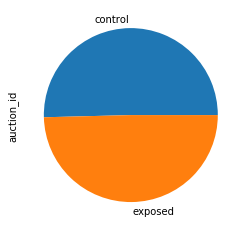

In [10]:
df.groupby('experiment')['auction_id'].count().plot.pie()

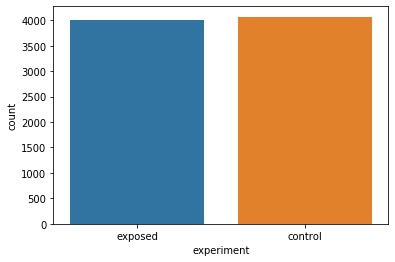

In [11]:
sns.countplot(data=df, x='experiment')

###### The number of users is roughly the same in the control and exposed group.

In [12]:
df['date'].nunique()

8

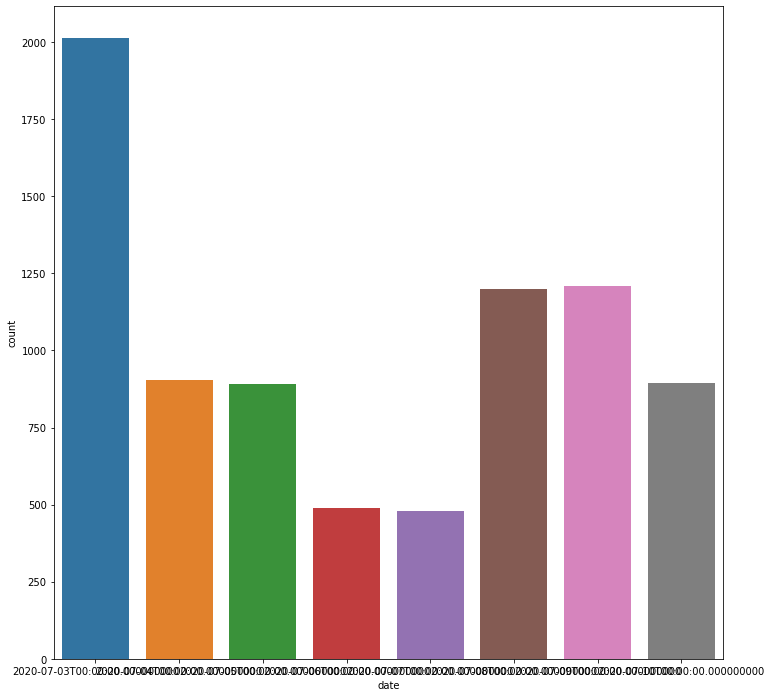

In [14]:
plt.figure(figsize=(12,12))
sns.countplot(data=df, x='date')

###### Most of the test data is obtained on 2020-07-03

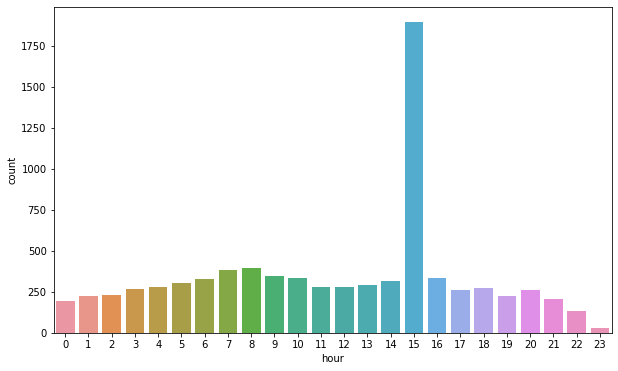

In [15]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='hour')

###### Most of the users saw the questionnaire at 15:00

In [16]:
print(f'device types: ',df['device_make'].nunique())
print(f'Operating system platforms:',df['platform_os'].nunique())
print(f'Browser types: ',df['browser'].nunique())

device types:  270
Operating system platforms: 3
Browser types:  15


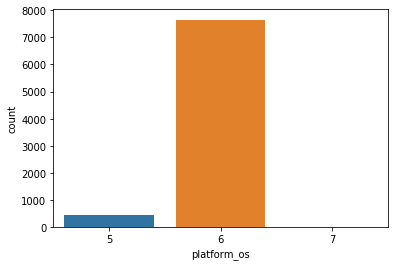

In [17]:
sns.countplot(data=df, x='platform_os')

###### most of the users use platform_os 6

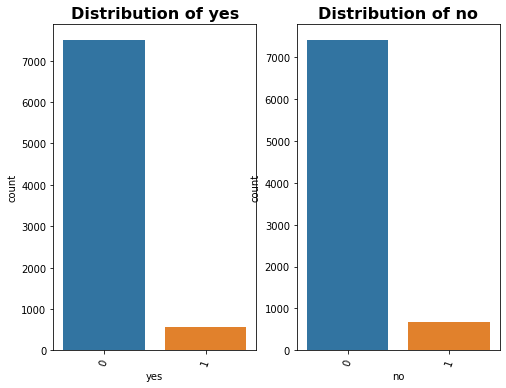

In [18]:
def count_plot(df,col1, col2):
    plt.figure(figsize=(8,6))
    plt.subplot(1,2,1)
    plt.title(f'Distribution of {col1}', size=16, fontweight='bold')
    plt.xticks(rotation=70)
    sns.countplot(data=df, x=col1)
    
    plt.subplot(1,2,2)
    plt.title(f'Distribution of {col2}', size=16, fontweight='bold')
    plt.xticks(rotation=70)
    sns.countplot(data=df, x=col2)
    plt.show()
count_plot(df,'yes', 'no')

###### This shows most of the participants didn't fill the questionnair

In [19]:
#users who responde to the questionnair
active_users=df[(df['yes'] ==1)|(df['no']==1)]
len(active_users)

1243

###### Only 1243 users out of 8077 responded to the questionnair

In [20]:
active_users.groupby(['experiment','yes','no'])['auction_id'].count()

experiment  yes  no
control     0    1     322
            1    0     264
exposed     0    1     349
            1    0     308
Name: auction_id, dtype: int64

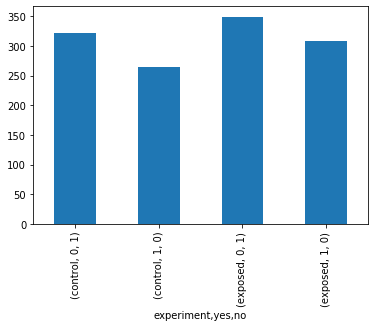

In [21]:
active_users.groupby(['experiment','yes','no'])['auction_id'].count().plot.bar()

# Classical and Sequential AB Testing

Since our objective is to test whether a newly designed ad resulted in an increase in brand awareness or not from a button click(on-off, 0and 1), this distribution is Bernoulli Distribution.

## Classical AB Testing

###### Null Hypothesis: there is no difference in brand awareness between the exposed and control groups in the current case

###### Alternative Hypothesis: there is a difference in brand awareness between the exposed and control groups in the current case(there is an increase in brand awareness in exposed group)

Because we’re performing an A/B Test on conversions which is a categorical variable
that follows a Bernoulli distribution, we’ll be using the Chi-Squared Test.
The steps to conducting a chi-squared test are as follows:
 1. Calculate the chi-squared test statistic
 2. Calculate the p-value
 3. Compare the p-value against the level of significance
This will make more sense when you follow along with the project walkthrough. And if p-value<0, we have a statistical evidence to reject the null hypothesis.


### Re-arrrange data into 2x2 for Chi-Squared

In [24]:
#Split Sample into control and exposed groups¶#
control=active_users[active_users['experiment']=='control']
exposed=active_users[active_users['experiment']=='exposed']

#collect responses to the questionair from both groups
control_yes=control.groupby('experiment').yes.sum()['control']
control_no=control.groupby('experiment').no.sum()['control']
exposed_yes=exposed.groupby('experiment').yes.sum()['exposed']
exposed_no=exposed.groupby('experiment').no.sum()['exposed']


In [28]:
# Create np array
T = np.array([[control_yes, control_no], [exposed_yes, exposed_no]])
#p-value
print(f'p-value:',scipy.stats.chi2_contingency(T,correction=False)[1])

p-value: 0.518486498219898


### p-value > level of significance(0.05), so we have not statical evidence to reject the null hypothesis. 
### i.e we cant say there is  difference in brand awareness between the exposed and control groups in the current case